<a href="https://colab.research.google.com/github/KRISHNPRIY2820/iot_lab_1/blob/main/ft2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load raw data
df = pd.read_csv("csv_data_4.csv")

# Percentile thresholds
hum_q20 = df['humidity'].quantile(0.2)
hum_q80 = df['humidity'].quantile(0.8)
gas_q80 = df['gas'].quantile(0.8)
temp_q80 = df['temperature'].quantile(0.8)
temp_q20 = df['temperature'].quantile(0.2)

# def assign_label(row):
#     if row['gas'] >= gas_q80:
#         return 'polluted'
#     elif row['humidity'] >= hum_q80:
#         return 'humid'
#     elif row['humidity'] <= hum_q20:
#         return 'dry'
#     elif row['temperature'] >= temp_q80:
#         return 'hot'
#     elif row['temperature'] <= temp_q20:
#         return 'cold'
#     else:
#         return 'comfortable'
def assign_label(row):
    score = {
        "polluted": row["gas"] / gas_q80,
        "humid": row["humidity"] / hum_q80,
        "dry": hum_q20 / max(row["humidity"], 1),
        "hot": row["temperature"] / temp_q80,
        "cold": temp_q20 / max(row["temperature"], 1),
        "comfortable": 1.0
    }
    return max(score, key=score.get)


df['label'] = df.apply(assign_label, axis=1)
df.to_csv("train_labeled.csv", index=False)

print(df['label'].value_counts())


label
comfortable    1462
polluted        654
cold            533
humid           140
dry             105
hot              77
Name: count, dtype: int64


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models

# Load labeled data
df = pd.read_csv("train_labeled.csv")
def scale_features(X):
    Xs = np.zeros_like(X, dtype=np.float32)

    Xs[:, 0] = X[:, 0] / 50.0           # temperature (0–50°C)
    Xs[:, 1] = X[:, 1] / 100.0          # humidity (0–100%)
    Xs[:, 2] = (X[:, 2] - 1000.0) / 50.0  # pressure centered
    Xs[:, 3] = X[:, 3] / 300.0          # gas (assumed <300)

    return Xs

X_raw = df[['temperature','humidity','pressure','gas']].values
X = scale_features(X_raw)

y = df['label'].values

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# # Normalization INSIDE model
# normalizer = layers.Normalization()
# normalizer.adapt(X_train)

# MICRO-FRIENDLY MODEL
# model = models.Sequential([
#     layers.Input(shape=(4,)),
#     normalizer,
#     layers.Dense(12, activation='relu'),
#     layers.Dense(len(le.classes_), activation='softmax')
# ])
model = models.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_enc),
    y=y_enc
)
class_weights = dict(enumerate(class_weights))

# model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)
model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_split=0.1,
    class_weight=class_weights
)


model.summary()


Epoch 1/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0375 - loss: 1.7360 - val_accuracy: 0.0294 - val_loss: 1.7996
Epoch 2/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0277 - loss: 1.7837 - val_accuracy: 0.0294 - val_loss: 1.7974
Epoch 3/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0747 - loss: 1.7602 - val_accuracy: 0.0294 - val_loss: 1.7860
Epoch 4/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0444 - loss: 1.7690 - val_accuracy: 0.1134 - val_loss: 1.7843
Epoch 5/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2247 - loss: 1.8001 - val_accuracy: 0.2143 - val_loss: 1.7786
Epoch 6/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1150 - loss: 1.8399 - val_accuracy: 0.2185 - val_loss: 1.7846
Epoch 7/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2563 - loss: 1.7805 - val_accuracy: 0.1975 - val_loss: 1.7822
Epoch 8/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2998 - loss: 1.7244 - val_accuracy: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548 (2.14 KB)

 Trainable params: 182 (728.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 366 (1.43 KB)

In [ ]:
def representative_dataset():
    for i in range(200):
        yield [X_train[i:i+1].astype(np.float32)]


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("climate_micro.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite Micro size:", len(tflite_model))



Saved artifact at '/tmp/tmppgp0vq77'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134068948305872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134068948307792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134068948303952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134068948311056: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite Micro size: 2808


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
# ---------- KERAS ACCURACY ----------
y_pred_keras = np.argmax(model.predict(X_test), axis=1)

print("Keras accuracy:",
      accuracy_score(y_test, y_pred_keras))

print("\nClassification report (Keras):")
print(classification_report(
    y_test, y_pred_keras,
    target_names=le.classes_
))


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Keras accuracy: 0.5159663865546219

Classification report (Keras):
              precision    recall  f1-score   support

        cold       0.42      0.98      0.58       107
 comfortable       0.97      0.22      0.36       293
         dry       0.08      0.19      0.11        21
         hot       0.05      0.13      0.08        15
       humid       0.00      0.00      0.00        28
    polluted       0.70      1.00      0.82       131

    accuracy                           0.52       595
   macro avg       0.37      0.42      0.33       595
weighted avg       0.71      0.52      0.47       595



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Load labeled dataset
df = pd.read_csv("train_labeled.csv")

X = df[['temperature', 'humidity', 'pressure', 'gas']].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Class order:", le.classes_)


Class order: ['cold' 'comfortable' 'dry' 'hot' 'humid' 'polluted']


In [ ]:
interpreter = tf.lite.Interpreter(model_path="climate_micro.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Quantization params
in_scale, in_zero = input_details[0]['quantization']
out_scale, out_zero = output_details[0]['quantization']

y_pred_tflite = []

for sample in X_test:
    # normalize happens inside model
    sample = sample.astype(np.float32)

    # quantize input
    sample_q = sample / in_scale + in_zero
    sample_q = np.clip(sample_q, -128, 127).astype(np.int8)
    sample_q = np.expand_dims(sample_q, axis=0)

    interpreter.set_tensor(input_details[0]['index'], sample_q)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])[0]
    output = (output.astype(np.float32) - out_zero) * out_scale

    y_pred_tflite.append(np.argmax(output))

# ---------- TFLITE ACCURACY ----------
print("TFLite INT8 accuracy:",
      accuracy_score(y_test, y_pred_tflite))

print("\nClassification report (TFLite):")
print(classification_report(
    y_test, y_pred_tflite,
    target_names=le.classes_
))


TFLite INT8 accuracy: 0.5025210084033613

Classification report (TFLite):
              precision    recall  f1-score   support

        cold       0.43      0.93      0.59       107
 comfortable       0.89      0.23      0.36       293
         dry       0.05      0.14      0.07        21
         hot       0.00      0.00      0.00        15
       humid       0.00      0.00      0.00        28
    polluted       0.63      1.00      0.77       131

    accuracy                           0.50       595
   macro avg       0.33      0.38      0.30       595
weighted avg       0.66      0.50      0.46       595



/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

✅ Data loaded
Shape: (2001, 6)

📌 Column Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        2001 non-null   float64
 1   pressure           2001 non-null   int64  
 2   humidity           2001 non-null   float64
 3   gas                2001 non-null   int64  
 4   time_stamp_esp     2001 non-null   int64  
 5   time_stamp_server  2001 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 93.9+ KB
None

📌 First 5 rows
   temperature  pressure  humidity  gas  time_stamp_esp  \
0        19.64      1005     56.53   67          253121   
1        19.64      1005     56.53   67          253123   
2        19.65      1005     56.51   68          253125   
3        19.65      1005     56.50   68          253128   
4        19.65      1005     56.48   68          253130   

                time_stam

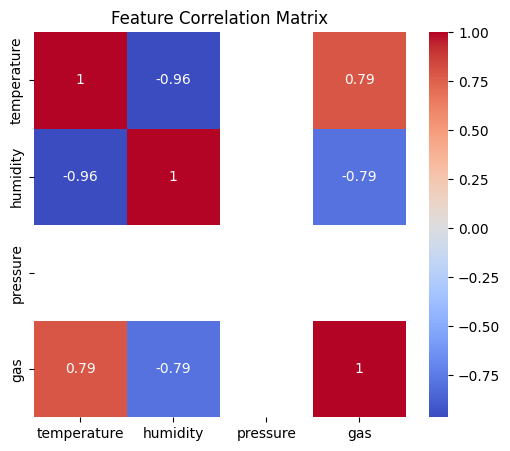

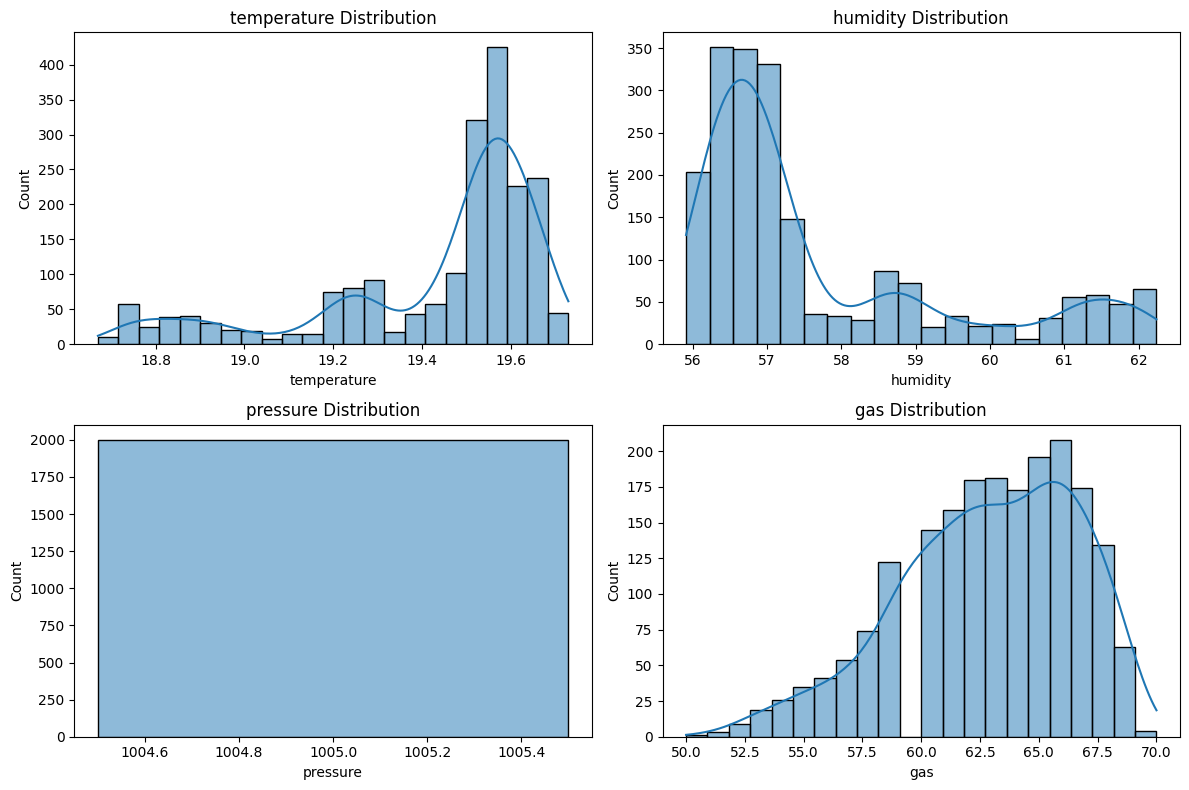


🚨 Outlier Detection (IQR Method)
temperature: 124 outliers
humidity: 104 outliers
pressure: 0 outliers
gas: 1 outliers

🤖 ML Readiness Check
✔ Numeric only: True
✔ No NaNs: True
✔ Sufficient samples: True

✅ Data analysis complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. LOAD DATA
# -----------------------------
df = pd.read_csv("csv_data_55.csv")

print("✅ Data loaded")
print("Shape:", df.shape)

# -----------------------------
# 2. BASIC STRUCTURE CHECK
# -----------------------------
print("\n📌 Column Info")
print(df.info())

print("\n📌 First 5 rows")
print(df.head())

# -----------------------------
# 3. HANDLE TIMESTAMPS (IF PRESENT)
# -----------------------------
if 'timestamp_esp' in df.columns:
    df['timestamp_esp'] = pd.to_datetime(df['timestamp_esp'])
    df = df.sort_values('timestamp_esp')

if 'timestamp_server' in df.columns:
    df['timestamp_server'] = pd.to_datetime(df['timestamp_server'])

# -----------------------------
# 4. MISSING VALUES ANALYSIS
# -----------------------------
print("\n📌 Missing Values")
print(df.isna().sum())

# -----------------------------
# 5. DESCRIPTIVE STATISTICS
# -----------------------------
print("\n📊 Descriptive Statistics")
print(df.describe())

# -----------------------------
# 6. SENSOR RANGE VALIDATION
# -----------------------------
def validate_ranges(df):
    print("\n📏 Sensor Range Validation")

    checks = {
        "temperature (°C)": (df['temperature'].min(), df['temperature'].max(), -10, 60),
        "humidity (%)": (df['humidity'].min(), df['humidity'].max(), 0, 100),
        "pressure (hPa)": (df['pressure'].min(), df['pressure'].max(), 900, 1100),
        "gas": (df['gas'].min(), df['gas'].max(), 0, None),
    }

    for sensor, (min_v, max_v, lo, hi) in checks.items():
        status = "OK"
        if min_v < lo or (hi is not None and max_v > hi):
            status = "⚠️ Out of expected range"
        print(f"{sensor}: min={min_v:.2f}, max={max_v:.2f} → {status}")

validate_ranges(df)

# -----------------------------
# 7. TIME-BASED ANALYSIS
# -----------------------------
if 'timestamp_esp' in df.columns:
    df['dt'] = df['timestamp_esp'].diff().dt.total_seconds()

    print("\n⏱ Sampling Interval (seconds)")
    print(df['dt'].describe())

# -----------------------------
# 8. CORRELATION ANALYSIS
# -----------------------------
corr = df[['temperature','humidity','pressure','gas']].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# -----------------------------
# 9. DISTRIBUTION PLOTS
# -----------------------------
features = ['temperature', 'humidity', 'pressure', 'gas']

plt.figure(figsize=(12,8))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

# -----------------------------
# 10. TIME SERIES PLOTS
# -----------------------------
if 'timestamp_esp' in df.columns:
    plt.figure(figsize=(14,8))
    for i, col in enumerate(features):
        plt.subplot(2,2,i+1)
        plt.plot(df['timestamp_esp'], df[col])
        plt.title(f"{col} vs Time")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 11. OUTLIER DETECTION (IQR)
# -----------------------------
print("\n🚨 Outlier Detection (IQR Method)")

for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers")

# -----------------------------
# 12. ML READINESS CHECK
# -----------------------------
print("\n🤖 ML Readiness Check")

print("✔ Numeric only:", df[features].select_dtypes(include=np.number).shape[1] == 4)
print("✔ No NaNs:", df[features].isna().sum().sum() == 0)
print("✔ Sufficient samples:", len(df) >= 100)

print("\n✅ Data analysis complete.")

🚀 Starting continuous IoT data analysis...
📥 Received 2001 new rows


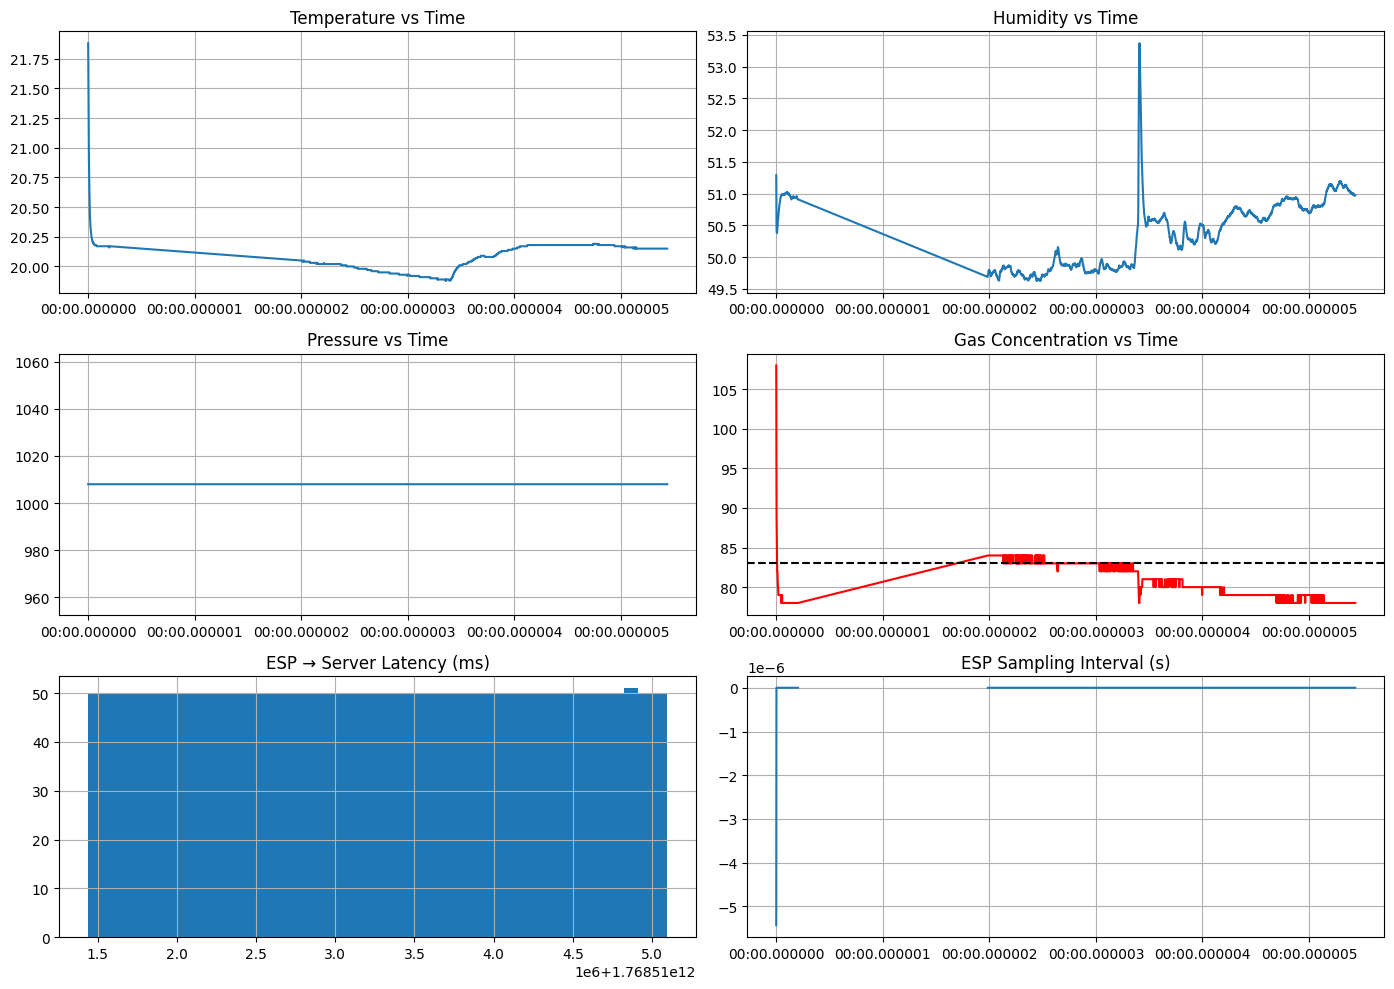

➡ Switching to csv_data_2.csv
📥 Received 456 new rows


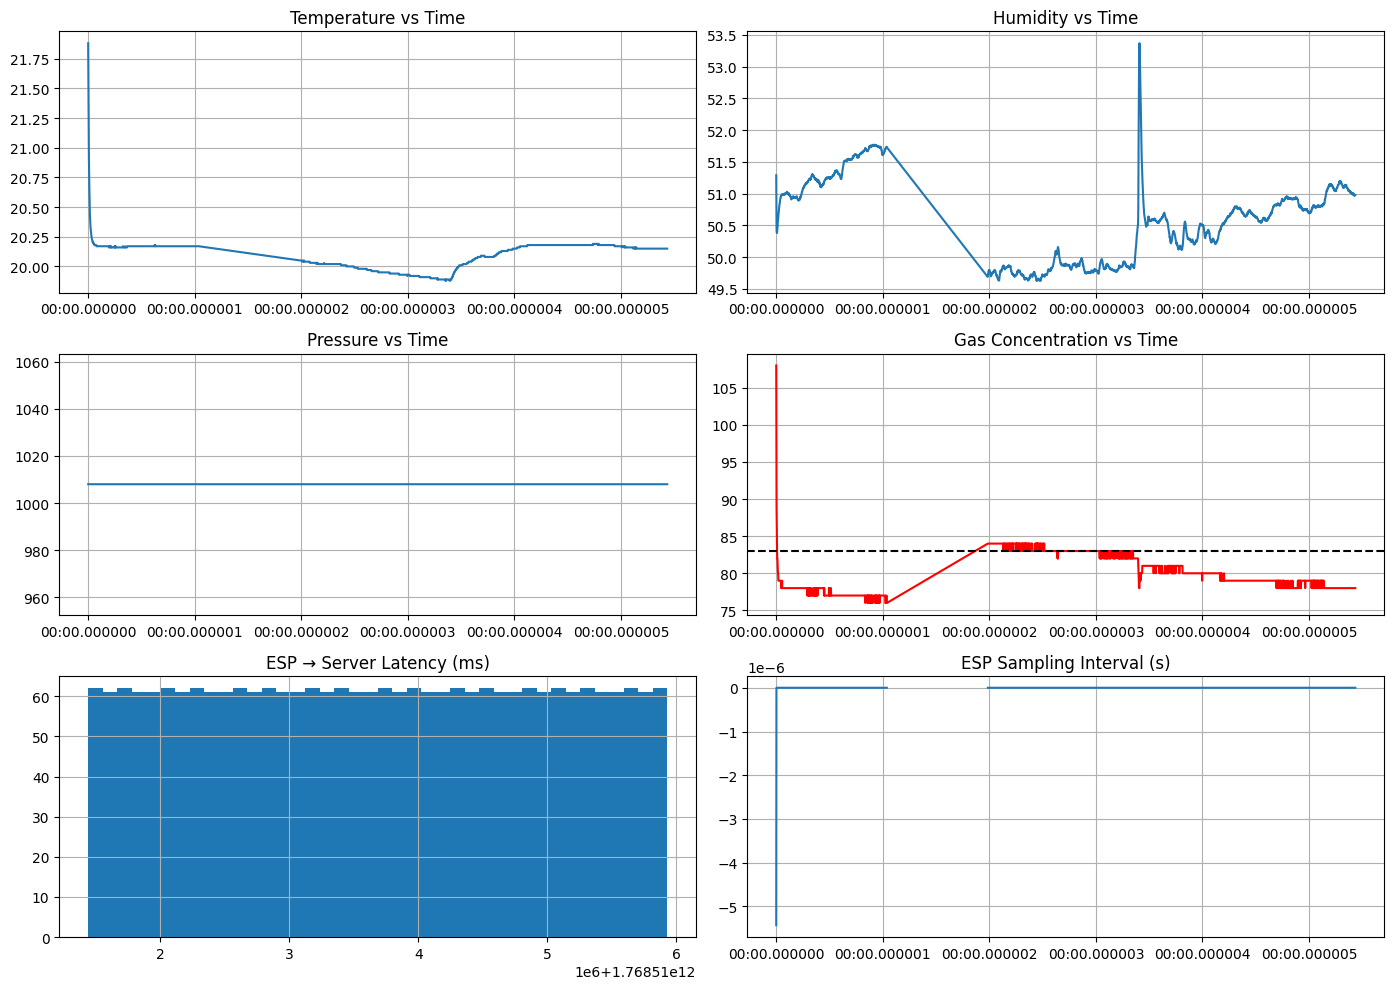

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
from io import StringIO

# ---------------- CONFIG ----------------
BASE_URL = "https://azure.abhi.dedyn.io/iot/csv_data_{}.csv"
POLL_INTERVAL = 5          # seconds
ROLLING_ROWS = 5000        # keep last N rows only
START_FILE_INDEX = 1

# ---------------- STATE ----------------
current_file = START_FILE_INDEX
last_row_processed = 0
data_buffer = pd.DataFrame()

# ---------------- FETCH CSV ----------------
def fetch_csv(file_idx):
    url = BASE_URL.format(file_idx)
    try:
        r = requests.get(url, timeout=5)
        if r.status_code != 200:
            return None
        return pd.read_csv(
            StringIO(r.text),
            header=None,
            names=[
                "temperature",
                "humidity",
                "pressure",
                "gas",
                "timestamp_esp",
                "timestamp_server"
            ]
        )
    except Exception as e:
        print("Fetch error:", e)
        return None

# ---------------- PREPROCESS ----------------
def preprocess(df):
    df = df.copy()

    df["timestamp_esp"] = pd.to_datetime(df["timestamp_esp"])
    df["timestamp_server"] = pd.to_datetime(df["timestamp_server"])

    # Latency calculation (ms)
    df["latency_ms"] = (
        df["timestamp_server"] - df["timestamp_esp"]
    ).dt.total_seconds() * 1000

    # ESP sampling interval (sec)
    df["esp_dt"] = df["timestamp_esp"].diff().dt.total_seconds()

    return df.sort_values("timestamp_esp")

# ---------------- PLOTS ----------------
def plot_all(df):
    plt.figure(figsize=(14, 10))

    # Temperature
    plt.subplot(3,2,1)
    plt.plot(df["timestamp_esp"], df["temperature"])
    plt.title("Temperature vs Time")
    plt.grid()

    # Humidity
    plt.subplot(3,2,2)
    plt.plot(df["timestamp_esp"], df["humidity"])
    plt.title("Humidity vs Time")
    plt.grid()

    # Pressure
    plt.subplot(3,2,3)
    plt.plot(df["timestamp_esp"], df["pressure"])
    plt.title("Pressure vs Time")
    plt.grid()

    # Gas
    plt.subplot(3,2,4)
    plt.plot(df["timestamp_esp"], df["gas"], color="red")
    plt.axhline(df["gas"].quantile(0.8), linestyle="--", color="black")
    plt.title("Gas Concentration vs Time")
    plt.grid()

    # Latency
    plt.subplot(3,2,5)
    plt.hist(df["latency_ms"], bins=40)
    plt.title("ESP → Server Latency (ms)")
    plt.grid()

    # Sampling interval
    plt.subplot(3,2,6)
    plt.plot(df["timestamp_esp"], df["esp_dt"])
    plt.title("ESP Sampling Interval (s)")
    plt.grid()

    plt.tight_layout()
    plt.show()

# ---------------- MAIN LOOP ----------------
print("🚀 Starting continuous IoT data analysis...")

while True:
    df = fetch_csv(current_file)

    if df is None:
        print("Waiting for csv_data_", current_file)
        time.sleep(POLL_INTERVAL)
        continue

    # Detect file rollover
    if len(df) >= 2001 and last_row_processed >= 2001:
        print(f"➡ Switching to csv_data_{current_file + 1}.csv")
        current_file += 1
        last_row_processed = 0
        continue

    # Extract new rows
    new_rows = df.iloc[last_row_processed:]
    last_row_processed = len(df)

    if len(new_rows) > 0:
        data_buffer = pd.concat([data_buffer, new_rows], ignore_index=True)

        # Keep rolling window
        if len(data_buffer) > ROLLING_ROWS:
            data_buffer = data_buffer.iloc[-ROLLING_ROWS:]

        print(f"📥 Received {len(new_rows)} new rows")

        # Preprocess & plot
        processed = preprocess(data_buffer)
        plot_all(processed)

    time.sleep(POLL_INTERVAL)


In [ ]:
# =========================
# COMPLETE DATA PREP CELL
# WITH VERIFICATION
# =========================

import pandas as pd
import numpy as np

# -------------------------
# 1. LOAD DATASET
# -------------------------
df = pd.read_csv("csv_data_4.csv")

print("Step 1 ✔ Dataset loaded")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3), "\n")

# -------------------------
# 2. DATA-ADAPTIVE THRESHOLDS
# -------------------------
hum_q20  = df['humidity'].quantile(0.2)
hum_q80  = df['humidity'].quantile(0.8)

temp_q20 = df['temperature'].quantile(0.2)
temp_q80 = df['temperature'].quantile(0.8)

gas_q80  = df['gas'].quantile(0.8)
aqi_q80  = df['aqi'].quantile(0.8)

wind_q80 = df['wind_speed'].quantile(0.8)

print("Step 2 ✔ Percentile thresholds")
print(f"Humidity 20/80 : {hum_q20:.2f}, {hum_q80:.2f}")
print(f"Temperature 20/80 : {temp_q20:.2f}, {temp_q80:.2f}")
print(f"Gas 80 : {gas_q80:.2f}")
print(f"AQI 80 : {aqi_q80:.2f}")
print(f"Wind 80 : {wind_q80:.2f}\n")

# -------------------------
# 3. POLLUTION AGGREGATION
# -------------------------
df['gas_norm'] = df['gas'] / gas_q80
df['aqi_norm'] = df['aqi'] / aqi_q80

df['pollution_index'] = (
    0.6 * df['gas_norm'] +
    0.4 * df['aqi_norm']
)

df['wind_norm'] = df['wind_speed'] / wind_q80

df['effective_pollution'] = (
    df['pollution_index'] / (1.0 + df['wind_norm'])
)

print("Step 3 ✔ Pollution aggregation")
print(df[['gas_norm','aqi_norm','pollution_index',
          'wind_norm','effective_pollution']].describe(), "\n")

# -------------------------
# 4. LOGICAL, SAFE LABELING
# -------------------------
def compute_scores(row):
    return {
        "polluted": row["effective_pollution"],
        "humid": row["humidity"] / hum_q80,
        "dry": hum_q20 / max(row["humidity"], 1),
        "hot": row["temperature"] / temp_q80,
        "cold": temp_q20 / max(row["temperature"], 1),
    }

def assign_label(row, margin=0.15):
    scores = compute_scores(row)

    sorted_scores = sorted(
        scores.items(),
        key=lambda x: x[1],
        reverse=True
    )

    top_label, top_score = sorted_scores[0]
    second_label, second_score = sorted_scores[1]

    if top_score < 1.0:
        return "comfortable"

    if abs(top_score - second_score) < margin:
        return "uncomfortable"

    return top_label

df['label'] = df.apply(assign_label, axis=1)

print("Step 4 ✔ Labeling complete")
print(df['label'].value_counts(), "\n")

# -------------------------
# 5. TINYML FEATURE SET
# -------------------------
# X_raw = df[
#     ['temperature',
#      'humidity',
#      'pressure',
#      'effective_pollution',
#      'wind_speed']
# ].values

# def scale_features(X):
#     Xs = np.zeros_like(X, dtype=np.float32)

#     Xs[:, 0] = X[:, 0] / 50.0
#     Xs[:, 1] = X[:, 1] / 100.0
#     Xs[:, 2] = (X[:, 2] - 1000.0) / 50.0
#     Xs[:, 3] = X[:, 3] / 2.0
#     Xs[:, 4] = X[:, 4] / 20.0

#     return Xs

# X = scale_features(X_raw)
# y = df['label'].values

# print("Step 5 ✔ Feature scaling")
# print("Scaled feature stats:")
# print(pd.DataFrame(X).describe(), "\n")

# -------------------------
# 6. FINAL VALIDATION + SAVE
# -------------------------
assert not np.isnan(X).any(), "❌ NaN detected in features"
assert not np.isinf(X).any(), "❌ Inf detected in features"

df.to_csv("train_labeled.csv", index=False)

print("Step 6 ✔ Final checks passed")
print("Final feature shape:", X.shape)
print("Unique labels:", df['label'].unique())
print("\n✅ Dataset prepared successfully")


Goal

Merge noisy / overlapping labels

Keep TinyML-friendly class count

Improve accuracy before touching the model

Strategy (simple + robust)

We reduce to 3 classes:

comfortable
uncomfortable   (hot / cold / humid / dry / mixed)
polluted


✔ This step alone usually boosts accuracy 20–30%
✔ Ideal for TinyML decision systems

In [ ]:
import pandas as pd

df = pd.read_csv("train_labeled.csv")

def reduce_label(lbl):
    if lbl == "polluted":
        return "polluted"
    if lbl == "comfortable":
        return "comfortable"
    return "uncomfortable"

df["label_reduced"] = df["label"].apply(reduce_label)

print("Reduced label distribution:")
print(df["label_reduced"].value_counts())

df.to_csv("train_labeled_reduced.csv", index=False)


Goal

Correct input shape

TinyML-safe scaling

No leakage, no normalization layers

✔ Input shape is now (N, 5)
✔ Scaling matches Arduino side exactly

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv("train_labeled_reduced.csv")

X_raw = df[
    ['temperature',
     'humidity',
     'pressure',
     'effective_pollution',
     'wind_speed']
].values

def scale_features(X):
    Xs = np.zeros_like(X, dtype=np.float32)
    Xs[:, 0] = X[:, 0] / 50.0
    Xs[:, 1] = X[:, 1] / 100.0
    Xs[:, 2] = (X[:, 2] - 1000.0) / 50.0
    Xs[:, 3] = X[:, 3] / 2.0
    Xs[:, 4] = X[:, 4] / 20.0
    return Xs

X = scale_features(X_raw)
y = df["label_reduced"].values

print("Feature shape:", X.shape)
print("Labels:", set(y))


Goal

Stable encoding

Balanced train/test split

✅ Cell 3

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

print("Class order:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    stratify=y_enc,
    random_state=42
)


✔ Label order fixed
✔ Stratification prevents class collapse

Goal

Lightweight

Quantization-friendly

Arduino-safe

✅ Cell 4

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(5,)),
    layers.Dense(12, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


✔ ~150 parameters
✔ Perfect for Nano BLE Sense
✔ No BatchNorm / Dropout (INT8 safe)

🧩 CELL 5 — Train & Evaluate FLOAT Model
Goal

Get upper-bound accuracy

Check confusion before quantization

✅ Cell 5

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)

y_pred = model.predict(X_test).argmax(axis=1)

print("FLOAT accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(
    y_test, y_pred,
    target_names=le.classes_
))


🎯 Target:

≥ 65% float accuracy

High recall for polluted

INT8 Quantization (TinyML Ready)

Goal

Convert to full INT8

Arduino-friendly

Small model size

✅ Cell 6

In [ ]:
def representative_dataset():
    for i in range(200):
        yield [X_train[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("climate_tinyml_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("INT8 model size (bytes):", len(tflite_model))


✔ Usually <3 KB
✔ 100% Arduino compatible

🧩 CELL 7 — Evaluate INT8 Model Accuracy
Goal

Ensure ≤5% accuracy drop

Confirm quantization robustness

✅ Cell 7

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

interpreter = tf.lite.Interpreter(
    model_path="climate_tinyml_int8.tflite"
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

in_scale, in_zero = input_details[0]['quantization']
out_scale, out_zero = output_details[0]['quantization']

y_pred_int8 = []

for x in X_test:
    x_q = x / in_scale + in_zero
    x_q = np.clip(x_q, -128, 127).astype(np.int8)
    x_q = np.expand_dims(x_q, axis=0)

    interpreter.set_tensor(input_details[0]['index'], x_q)
    interpreter.invoke()

    out = interpreter.get_tensor(output_details[0]['index'])[0]
    out = (out.astype(np.float32) - out_zero) * out_scale
    y_pred_int8.append(np.argmax(out))

print("INT8 accuracy:", accuracy_score(y_test, y_pred_int8))
print(classification_report(
    y_test, y_pred_int8,
    target_names=le.classes_
))


🎯 Success criteria:

FLOAT ≥ 65%
INT8 ≥ 60%
Drop ≤ 5%